# Kinematics of [O III] with PZ cube

We will calculate the velocity moments for [O III] from the Peter Zeidler cube to compare with the ones we already calculated for H alpha, and also with the [O III] measurements from the pipeline ESO cube.  There are some advantages in using [O III] over H alpha:

* There are two lines with a known ratio, which allows checking the intensity zero-point easily
* Thermal broadening is less
* Photospheric absorption is less

On the other hand, there is at least one disadvantage:

* The spectral resolution is lower (in velocity units)


Load libraries and data cube (identical to earlier notebooks):

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import astropy.units as u

sns.set_context("talk")
sns.set_color_codes()

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "PeterZeidler" / "DATACUBE_FINAL_fwhm_cor.fits"
cube = Cube(str(fitsfilepath))

I have now moved functions for dealing with the velocity moments to a separate library:

In [3]:
import sys
from whispy import moments

Where to save figures and FITS images:

In [4]:
moments.FIGPATH = Path("../../figs")
moments.SAVEPATH = Path("../../data")

## Choose the wavelength range

### Broad overview

First we inspect the spectrum in 6 broad horizontal strips across the image, from south to north.

In [5]:
jstrips = [
    [0, 50],
    [50, 100],
    [100, 150],
    [150, 200],
    [200, 250],
    [250, -1],
]

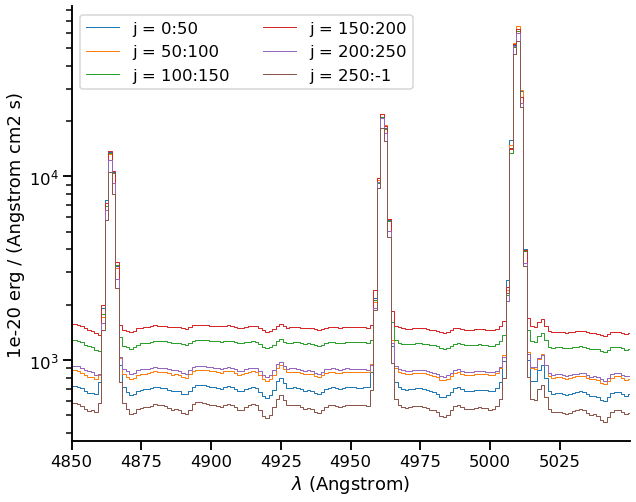

In [6]:
wide_band = cube.select_lambda(4850, 5050)
fig, ax = plt.subplots(figsize=(10, 8))
for j1, j2 in jstrips:
    (wide_band[:, j1:j2, :].mean(axis=(1, 2)).plot(label=f"j = {j1}:{j2}"))
ax.legend(ncol=2)
ax.set(yscale="log")
sns.despine()

So, this makes it look like all the lines are positive (and hopefully for the PZ cube this is the case).
* The other strong line we see is H beta 4861.
* The other weak lines that we see are He I 4922 and 5016 Å (and marginally [Fe III] 4987)
* If we compare with the original version, the continuum is not so flat, but instead shows lots of undulations

### Narrow in on the [O III] doublet

Set some limits for the continuum and line extraction:

In [7]:
wlim = {
    "4959": {
        "core": [4953.0, 4969.0],
        "blue": [4947.0, 4953.0],
        "red": [4969.0, 4975.0],
    },
    "5007": {
        "core": [5002.0, 5016.0],
        "blue": [4995.0, 5001.0],
        "red": [5022.0, 5028.0],
    },
}
rangecolors = {"core": "g", "blue": "b", "red": "r"}

Plot these limits zoomed in on the two [O III] lines:

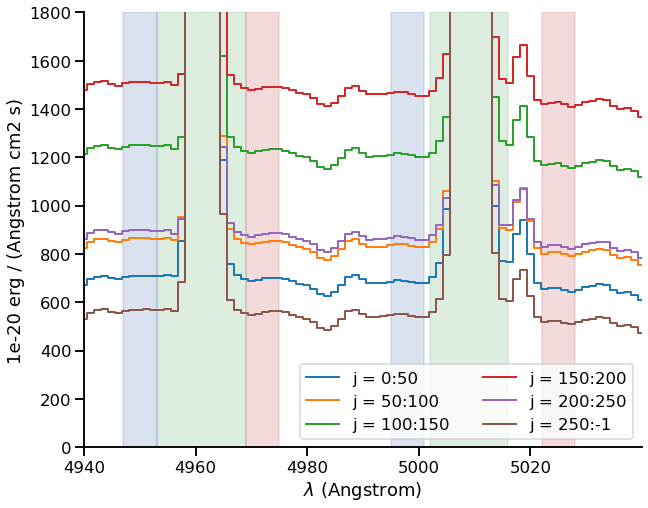

In [8]:
medium_band = cube.select_lambda(4940, 5040)
fig, ax = plt.subplots(figsize=(10, 8))
for j1, j2 in jstrips:
    (
        medium_band[:, j1:j2, :]
        .mean(axis=(1, 2))
        .plot(label=f"j = {j1}:{j2}", linewidth=2)
    )

for line, linedata in wlim.items():
    for span, spandata in linedata.items():
        ax.axvspan(
            spandata[0], spandata[1], alpha=0.2, color=rangecolors[span], zorder=-100
        )
ax.legend(ncol=2)
ax.set(yscale="linear", ylim=[0.0, 1800])
sns.despine()

That seems to look fine.  Note that the red continuum band for 5007 is separated a bit from the core to allow space for the He I line (although it is so weak that this probably doesn't matter).

### Do continuum subtraction

Now, we can use the same `wlim` data to extract the line and continuum:

In [9]:
def extract_core_and_cont(cube, spandata):
    """Return continuum-subtracted line core and continuum map

    The line core is a 3D cube over the narrow core wavelengths
    """
    cblue = cube.select_lambda(*spandata["blue"]).mean(axis=0)
    cred = cube.select_lambda(*spandata["red"]).mean(axis=0)
    cont = 0.5 * (cblue + cred)
    core = cube.select_lambda(*spandata["core"]) - cont
    return core, cont

In [10]:
core5007, cont5007 = extract_core_and_cont(medium_band, wlim["5007"])
core4959, cont4959 = extract_core_and_cont(medium_band, wlim["4959"])

Plot the line core and the continuum for 5007 and 4959

<ipython-input-1-dc853e2d1974>:12: UserWarning: No contour levels were found within the data range.
  axes[0, 0].contour(core5007.sum(axis=0).data, levels=[0.0], colors="r")
<ipython-input-1-dc853e2d1974>:14: UserWarning: No contour levels were found within the data range.
  axes[1, 0].contour(cont5007.data, levels=[0.0], colors="r")
<ipython-input-1-dc853e2d1974>:15: UserWarning: No contour levels were found within the data range.
  axes[1, 1].contour(cont4959.data, levels=[0.0], colors="r")


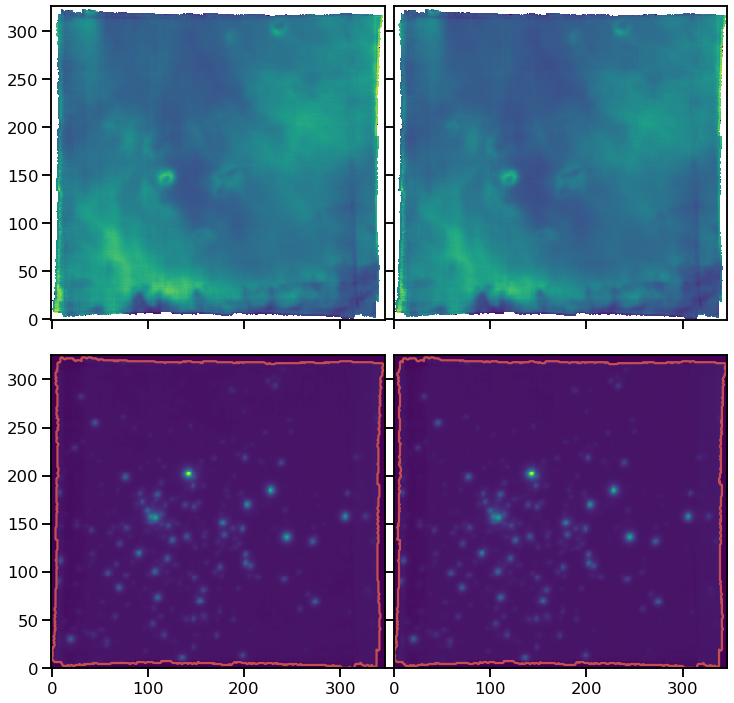

In [11]:
fig, axes = plt.subplots(
    2,
    2,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)
core5007.sum(axis=0).plot(ax=axes[0, 0])
core4959.sum(axis=0).plot(ax=axes[0, 1])
cont5007.plot(ax=axes[1, 0], scale="sqrt")
cont4959.plot(ax=axes[1, 1], scale="sqrt")
axes[0, 0].contour(core5007.sum(axis=0).data, levels=[0.0], colors="r")
axes[0, 1].contour(core4959.sum(axis=0).data, levels=[0.0], colors="r")
axes[1, 0].contour(cont5007.data, levels=[0.0], colors="r")
axes[1, 1].contour(cont4959.data, levels=[0.0], colors="r")
fig.tight_layout(pad=0)

The red contours show the zero level. Unlike with the ESO cube, there are no negative regions in either line or continuum. This is good.

## Wavelength moments

We now use the functions defined in my `moments` module (part of whispy package).

### First look without having fixed the sky

This comes out fine

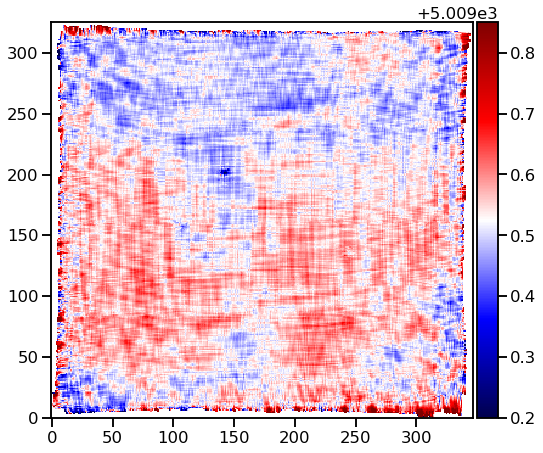

In [12]:
mom5007 = moments.find_moments(core5007)
fig, ax = plt.subplots(figsize=(8, 8))
mom5007[1].plot(
    cmap="seismic",
    vmin=5009.2,
    vmax=5009.85,
    colorbar="v",
)

This looks similar to the sky-corrected version that I obtained from the ESO cube, although the amplitude of artifacts (cross-hatched patterns) seems larger

So we skip entirely the correction steps we did lat time.


But we do do the side-by-side comparison of the first moment for 5007 and 4959:

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


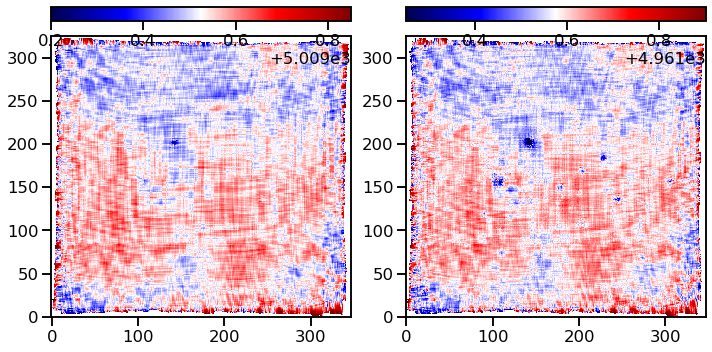

In [13]:
mom5007 = moments.find_moments(core5007)
mom4959 = moments.find_moments(core4959)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mom5007[1].plot(
    cmap="seismic",
    vmin=5009.2,
    vmax=5009.85,
    colorbar="h",
    ax=axes[0],
)
mom4959[1].plot(
    cmap="seismic",
    vmin=4961.25,
    vmax=4961.9,
    colorbar="h",
    ax=axes[1],
)
fig.tight_layout(h_pad=10)

These look very similar to the H alpha map in general.  They are also extremely similar to one another.  Both of these facts are reassuring.

On the negative side, as mentioned above, we see a lot of small scale patterming, which seem to be due to rebinning onto the uniform wavelength grid of the cube

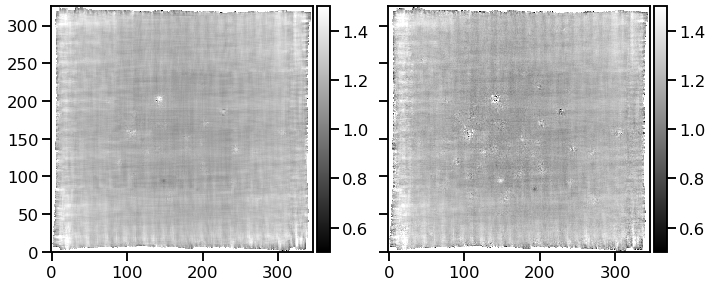

In [14]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    sharey=True,
)
mom5007[2].plot(
    cmap="gray",
    vmin=0.5,
    vmax=1.5,
    colorbar="v",
    ax=axes[0],
)
mom4959[2].plot(
    cmap="gray",
    vmin=0.5,
    vmax=1.5,
    colorbar="v",
    ax=axes[1],
)
fig.tight_layout()

These maps of sigma seem to show less artifacts than the equivalent ones from the ESO cube.

(5009.531192596469, 4961.581474976288)

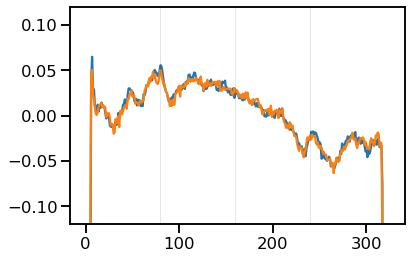

In [15]:
fig, ax = plt.subplots()
wav5007 = np.median(mom5007[1].data.data)
wav4959 = np.median(mom4959[1].data.data)
# ax.plot(mom5007[1].data.mean(axis=1) - wav5007)
# ax.plot(mom4959[1].data.mean(axis=1) - wav4959)
ax.plot(np.median(mom5007[1].data.data, axis=1) - wav5007)
ax.plot(np.median(mom4959[1].data.data, axis=1) - wav4959)
ax.set(ylim=[-0.12, 0.12])
for i0 in [80, 160, 240]:
    ax.axvline(i0, lw=0.5, color="k", alpha=0.2)
wav5007, wav4959

This is the median N-S (vertical) profile of the map, which nicely shows the blue-red-blue pattern as one goes from south to north. The agreement between the two doublet components is excellent. The pattern is similar to what I got with the ESO cube, except the total variation is a bit smaller.

[(-0.12, 0.12)]

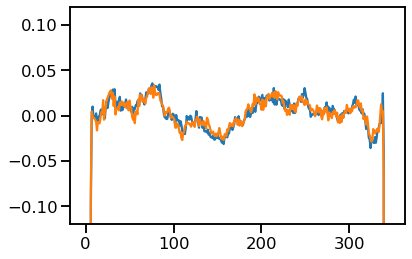

In [16]:
fig, ax = plt.subplots()
ax.plot(np.median(mom5007[1].data.data, axis=0) - wav5007)
ax.plot(np.median(mom4959[1].data.data, axis=0) - wav4959)
# ax.plot(mom5007[1].data.mean(axis=0) - wav5007)
# ax.plot(mom4959[1].data.mean(axis=0) - wav4959)
ax.set(ylim=[-0.12, 0.12])
# for i0 in [80, 160, 240]:
#    ax.axvline(i0, lw=0.5, color="k", alpha=0.2)

And this is the same in the E-W (horizontal) direction. There is less horizontal variation than vertical variation, as is obvious from just looking at the maps.

In [17]:
import pandas as pd

In [18]:
save_pars_5007 = dict(
    label="5007",
    flabel="ngc346-PZ-oiii",
    restwav=5006.84,
    irange=[5.0e4, 3.0e5],
    vrange=[150, 175],
    srange=[60, 90],
)
plot_pars_5007 = dict(
    ilabel="[O III]",
    **save_pars_5007,
)

In [19]:
moments.save_moments_to_fits(
    mom5007,
    **save_pars_5007,
)

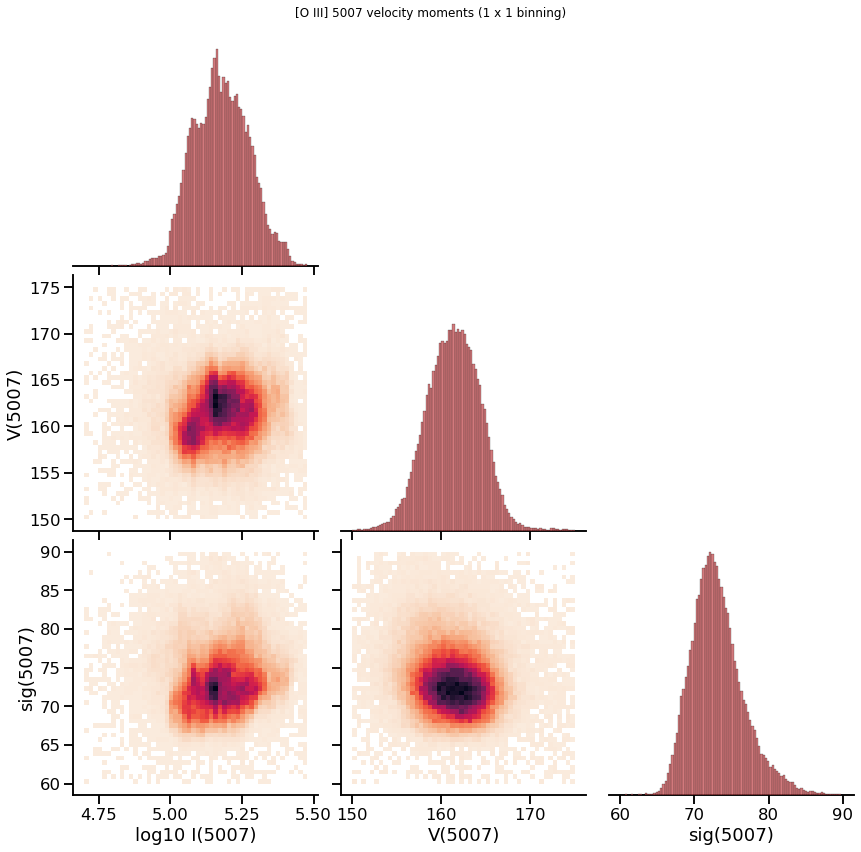

In [20]:
g = moments.moments_corner_plot(mom5007, rebin=1, **plot_pars_5007)

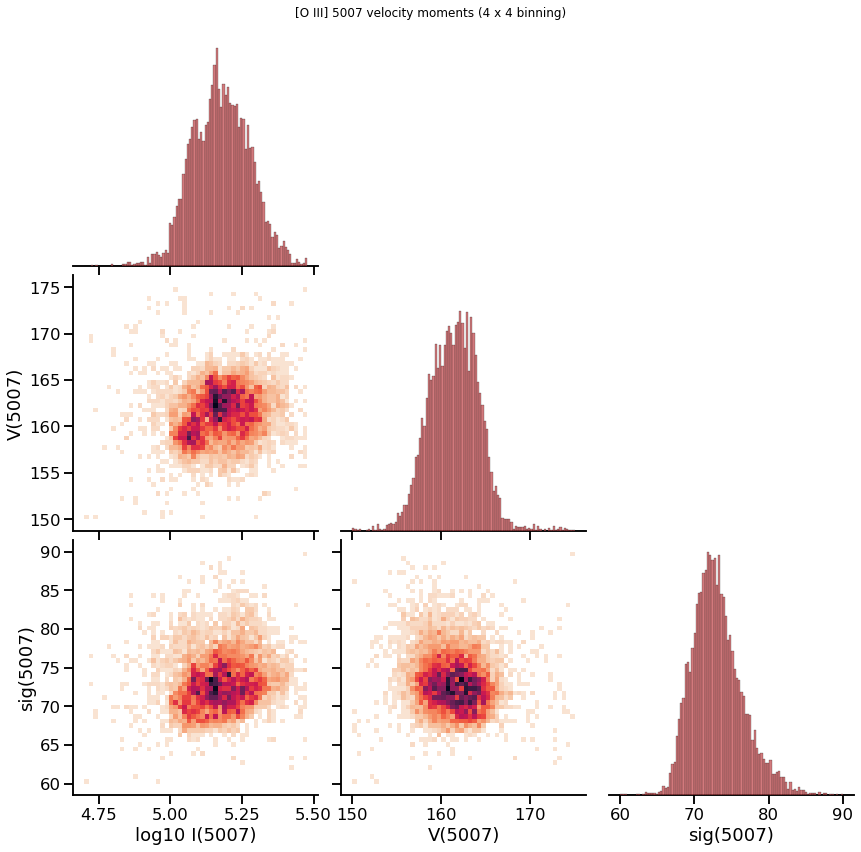

In [21]:
g = moments.moments_corner_plot(mom5007, rebin=4, **plot_pars_5007)

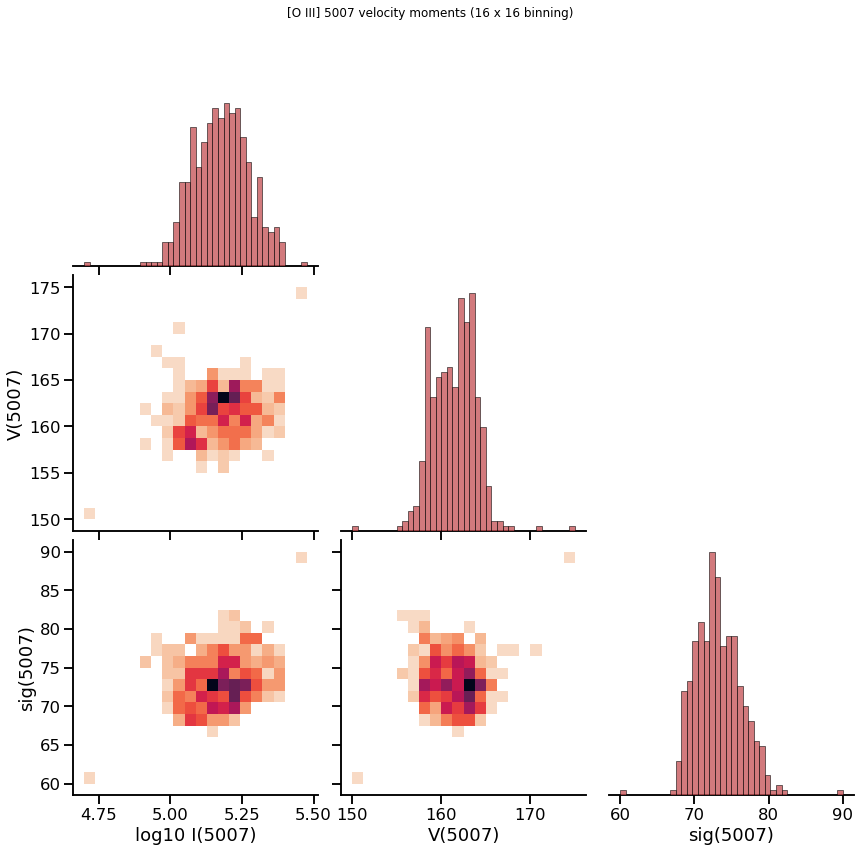

In [22]:
g = moments.moments_corner_plot(
    mom5007,
    rebin=16,
    **plot_pars_5007,
    hist_bins=40,
    image_bins=20,
)

In [23]:
m = (
    mom5007[0].mask
    | (mom5007[0].data < 2e4)
    | (mom5007[1].data < 5009.2)
    | (mom5007[1].data > 5009.8)
    | (mom5007[2].data < 0.8)
    | (mom5007[2].data > 1.5)
)
df = pd.DataFrame(
    {
        "log10 I(5007)": np.log10(mom5007[0].data[~m]),
        "V(5007)": 3e5 * (mom5007[1].data[~m] - 5006.84) / 5006.84,
        "sig(5007)": 3e5 * mom5007[2].data[~m] / 5006.84,
    }
)
df.describe()

,log10 I(5007),V(5007),sig(5007)
count,104297.000000,104297.000000,104297.000000
mean,5.176317,161.512527,73.205116
std,0.102403,3.205408,3.723448
min,4.346572,141.457073,48.475103
25%,5.105234,159.436270,70.718857
50%,5.174996,161.549225,72.788928
75%,5.246648,163.605657,75.217412
max,5.575860,177.352193,89.870283


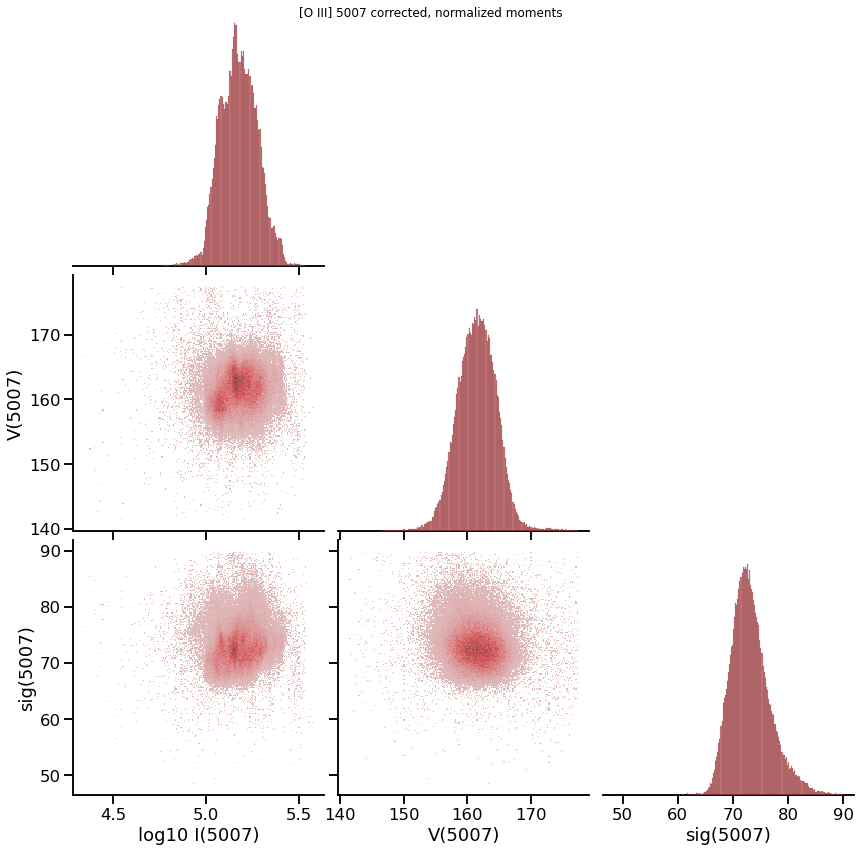

In [24]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[O III] 5007 corrected, normalized moments")
g.tight_layout(pad=0)

In [25]:
m = (
    mom4959[0].mask
    | (mom4959[0].data < 0.67e4)
    | (mom4959[1].data < 4961.2)
    | (mom4959[1].data > 4961.8)
    | (mom4959[2].data < 0.8)
    | (mom4959[2].data > 1.5)
)
df4959 = pd.DataFrame(
    {
        "log10 I(4959)": np.log10(mom4959[0].data[~m]),
        "V(4959)": 3e5 * (mom4959[1].data[~m] - 4958.91) / 4958.91,
        "sig(4959)": 3e5 * mom4959[2].data[~m] / 4958.91,
    }
)
df4959.describe()

,log10 I(4959),V(4959),sig(4959)
count,103870.000000,103870.000000,103870.000000
mean,4.696175,161.807742,73.454134
std,0.102079,3.229118,4.416415
min,3.891597,138.658270,48.405458
25%,4.624608,159.747478,70.581360
50%,4.694644,161.923145,73.102339
75%,4.766471,163.964018,75.915062
max,5.087133,174.828986,90.727903


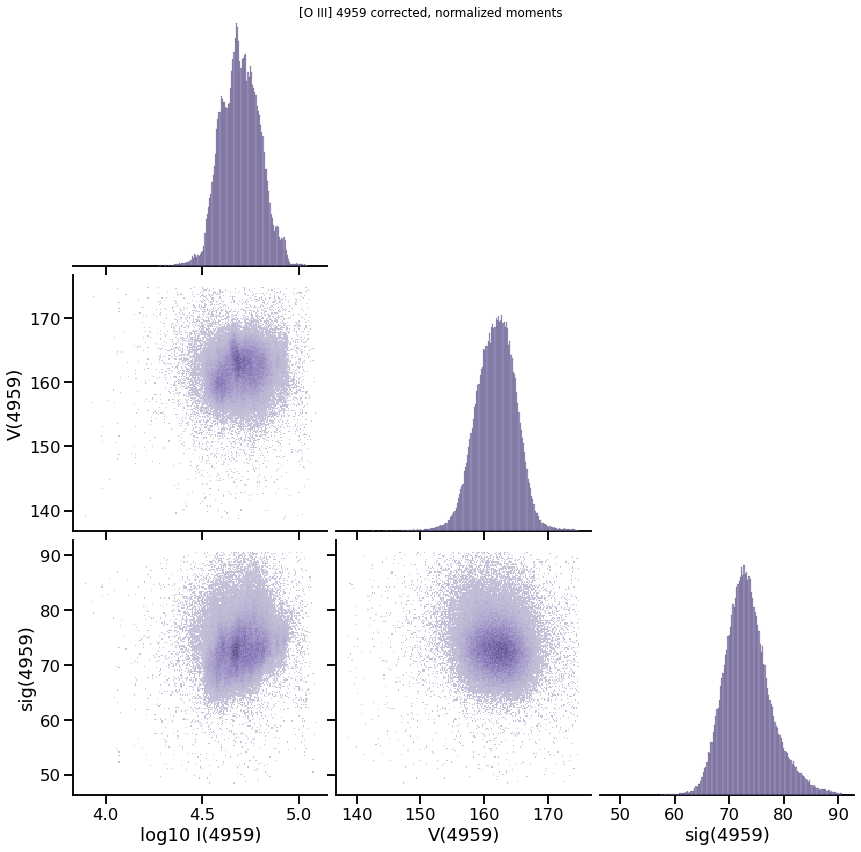

In [26]:
g = sns.pairplot(
    df4959,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="m"),
    diag_kws=dict(color="m"),
)
g.fig.suptitle("[O III] 4959 corrected, normalized moments")
g.tight_layout(pad=0)

The distributions are very consistent between the two [O III] lines.  They are also quite similar to H alpha, especially in the mid-range of intensity.

Unlike in the ESO cube, there is not really a bimodal distribution in the velocities of either line. The marginal histogram is single-peaked, with a maximum at about 162 km/s.

However, on the joint I-v distribution, we can see evidence of a multi-peaked structure. The 162 km/s peak corresponds to the intermediate brightness values. Lower brightness values have a distinct peak at 159 km/s. And then the brightest pixels also seem to move twoards slightly bluer velocities (160 km/s). Finally, the intermediate brightnesses show a "spike" towards higher velocities: 165 km/s.

The line width does not vary with velocity, but there is some evidence for structure in the I-sigma plot.

Now look at the cross-correlations between the two lines:

In [27]:
m = (
    mom5007[0].mask
    | (mom5007[0].data < 3e4)
    | (mom5007[1].data < 5009.3)
    | (mom5007[1].data > 5009.8)
    | (mom5007[2].data < 1.0)
    | (mom5007[2].data > 1.5)
    | mom4959[0].mask
    | (mom4959[0].data < 1e4)
    | (mom4959[1].data < 4961.3)
    | (mom4959[1].data > 4961.8)
    | (mom4959[2].data < 1.0)
    | (mom4959[2].data > 1.5)
)
df2 = pd.DataFrame(
    {
        "log10 I(5007)": np.log10(mom5007[0].data[~m]),
        "V(5007)": 3e5 * (mom5007[1].data[~m] - 5006.84) / 5006.84,
        "sig(5007)": 3e5 * mom5007[2].data[~m] / 5006.84,
        "log10 I(4959)": np.log10(mom4959[0].data[~m]),
        "V(4959)": 3e5 * (mom4959[1].data[~m] - 4958.91) / 4958.91,
        "sig(4959)": 3e5 * mom4959[2].data[~m] / 4958.91,
    }
)
df2.corr()

,log10 I(5007),V(5007),sig(5007),log10 I(4959),V(4959),sig(4959)
log10 I(5007),1.000000,0.136689,0.128825,0.997253,0.112606,0.168188
V(5007),0.136689,1.000000,-0.131494,0.132539,0.722942,-0.213956
sig(5007),0.128825,-0.131494,1.000000,0.130641,-0.002118,0.849591
log10 I(4959),0.997253,0.132539,0.130641,1.000000,0.109441,0.176001
V(4959),0.112606,0.722942,-0.002118,0.109441,1.000000,-0.143941
sig(4959),0.168188,-0.213956,0.849591,0.176001,-0.143941,1.000000


In [28]:
xvars = [_ for _ in df2.columns if "5007" in _]
yvars = [_ for _ in df2.columns if "4959" in _]
xvars, yvars

(['log10 I(5007)', 'V(5007)', 'sig(5007)'],
 ['log10 I(4959)', 'V(4959)', 'sig(4959)'])

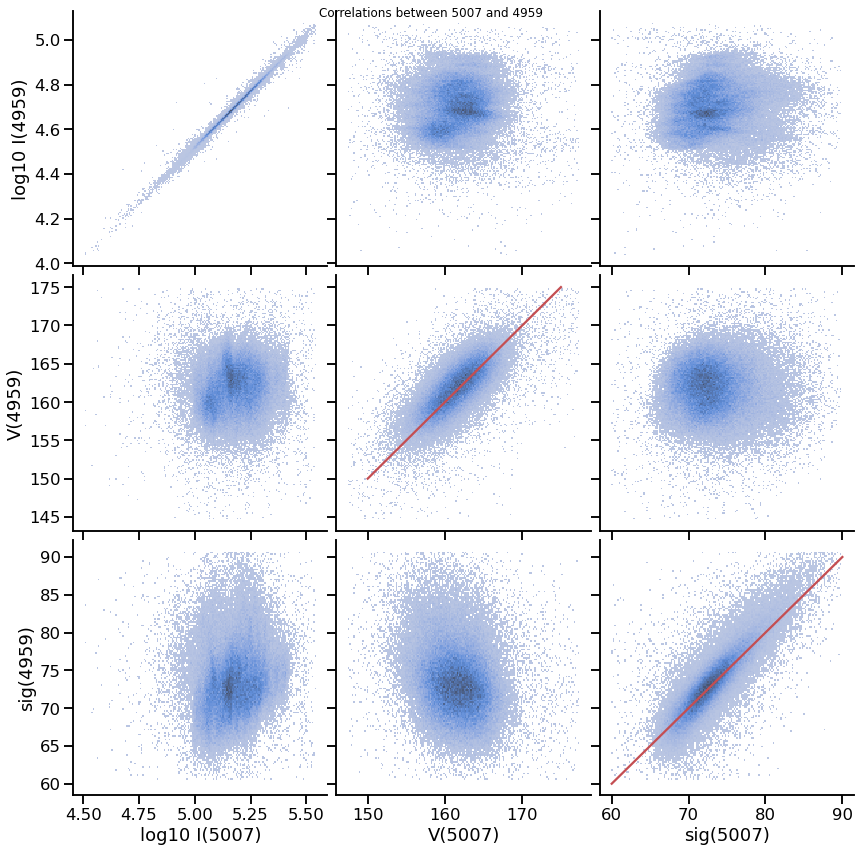

In [29]:
g = sns.pairplot(
    df2,
    kind="hist",
    height=4,
    x_vars=xvars,
    y_vars=yvars,
    plot_kws=dict(color="b"),
)
g.axes[1, 1].plot([150, 175], [150, 175], c="r")
g.axes[2, 2].plot([60, 90], [60, 90], c="r")
g.fig.suptitle("Correlations between 5007 and 4959")
g.tight_layout(pad=0)

That all looks good, although the correlation coefficients for V-V and sig-sig are a bit lower than for the ESO cube, presumably due to the pattern noise.

In [30]:
df3 = df2[["log10 I(5007)"]].copy()
df3["5007 / 4959"] = 10 ** (df2["log10 I(5007)"] - df2["log10 I(4959)"])
df3["dV"] = df2["V(5007)"] - df2["V(4959)"]
df3["sig ratio"] = df2["sig(5007)"] / df2["sig(4959)"]
df3.describe()

,log10 I(5007),5007 / 4959,dV,sig ratio
count,103179.000000,103179.000000,103179.000000,103179.000000
mean,5.176979,3.023410,-0.314479,0.996839
std,0.100235,0.051664,2.309565,0.030646
min,4.507419,1.582718,-17.138440,0.696705
25%,5.105938,3.000251,-1.733586,0.980619
50%,5.175240,3.023645,-0.345439,0.996321
75%,5.246558,3.047130,1.044675,1.012818
max,5.542450,5.323964,23.035282,1.319371


In [31]:
m = (
    (df3["5007 / 4959"] < 2.9)
    | (df3["5007 / 4959"] > 3.1)
    | (np.abs(df3["dV"]) > 5.0)
    | (df3["sig ratio"] < 0.8)
    | (df3["sig ratio"] > 1.1)
)

df3 = df3[~m]
df3.corr()

,log10 I(5007),5007 / 4959,dV,sig ratio
log10 I(5007),1.000000,-0.018792,0.030324,-0.130879
5007 / 4959,-0.018792,1.000000,0.036653,0.232276
dV,0.030324,0.036653,1.000000,-0.066939
sig ratio,-0.130879,0.232276,-0.066939,1.000000


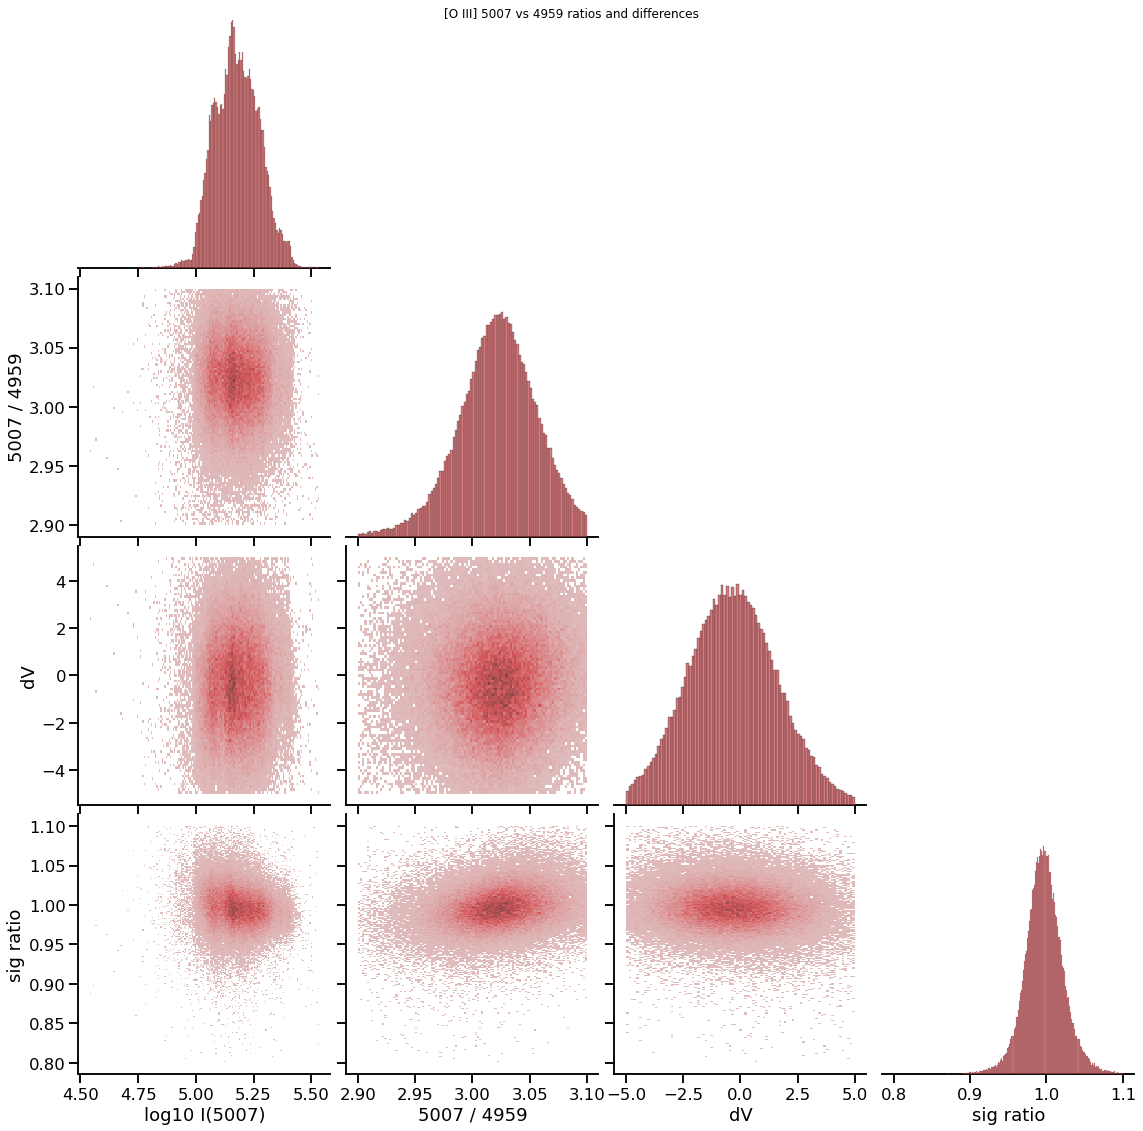

In [32]:
g = sns.pairplot(
    df3,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[O III] 5007 vs 4959 ratios and differences")
g.tight_layout(pad=0)

No meaningful correlations or trends here, which is good. And better than the ESO cube, where there were several. There is a slight tendency for sigma ratio to increase with intensity ratio, which could be evidence that there is an additional line that blends with 5007.